# 音乐曲风分类 with CNN

## 载入套件

In [1]:
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
import os
import math
import audio_util

## 设定参数

In [2]:
PATH_DATASETS = "./audio" # 预设路径
BATCH_SIZE = 5  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步骤1：下载 GTZAN资料集，并建立 Dataset

In [3]:
dataset_GTZAN = torchaudio.datasets.GTZAN(PATH_DATASETS, download=True)

In [4]:
dataset_GTZAN[0]

(tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.0556, -0.0611, -0.0642]]),
 22050,
 'blues')

In [5]:
dataset_GTZAN[0][0].shape

torch.Size([1, 661794])

In [6]:
dataset_GTZAN[1][0].shape

torch.Size([1, 661794])

In [1]:
f'{661794 / 22050} 秒'

'30.013333333333332 秒'

## 步骤2：资料清理，此步骤无需进行

## 步骤3：特征工程

In [7]:
# label类别
gtzan_genres = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

In [8]:
n_fft = 2048
hop_length = 512
n_mels = 256
n_mfcc = 256

class GTZAN_DS(Dataset):
    def __init__(self, dataset1):
        self.dataset1 = dataset_GTZAN
        
    def __len__(self):
          return len(self.dataset1)  

    def __getitem__(self, n):
        waveform , sample_rate, label = self.dataset1[n]
        mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,   # MFCC 个数
            melkwargs={
              'n_fft': n_fft,
              'n_mels': n_mels,
              'hop_length': hop_length,
              'mel_scale': 'htk',
            }
        )
        mfcc = mfcc_transform(waveform)
        # print(mfcc.shape)
        mfcc = mfcc[:, :, :1280]
        return mfcc, gtzan_genres.index(label)
    
dataset = GTZAN_DS(dataset_GTZAN)

## 步骤4：资料分割

In [9]:
from torch.utils.data import random_split

test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(800, 200)

## 建立 DataLoader

In [10]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE*2, shuffle=False)

## 步骤5：建立模型结构

In [11]:
# 建立模型
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # Conv2d 参数： in-channel, out-channel, kernel size, Stride, Padding
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(655360, num_classes)
        # self.fc2 = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        #out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out

model = ConvNet().to(device)

## 步骤6：模型训练

In [12]:
epochs = 10
lr=0.01

# 设定优化器(optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        # if batch_idx == 0 and epoch == 1: print(type(data), type(target))
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        # if batch_idx == 0 : print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [   50 / 800] (6 %)  Loss: 2389.155518
Epoch 1: [  100 / 800] (12 %)  Loss: 952.834778
Epoch 1: [  150 / 800] (19 %)  Loss: 429.335541
Epoch 1: [  200 / 800] (25 %)  Loss: 144.052155
Epoch 1: [  250 / 800] (31 %)  Loss: 140.000488
Epoch 1: [  300 / 800] (38 %)  Loss: 121.586075
Epoch 1: [  350 / 800] (44 %)  Loss: 69.608612
Epoch 1: [  400 / 800] (50 %)  Loss: 37.137997
Epoch 1: [  450 / 800] (56 %)  Loss: 44.542061
Epoch 1: [  500 / 800] (62 %)  Loss: 48.163116
Epoch 1: [  550 / 800] (69 %)  Loss: 22.356218
Epoch 1: [  600 / 800] (75 %)  Loss: 5.885140
Epoch 1: [  650 / 800] (81 %)  Loss: 61.684814
Epoch 1: [  700 / 800] (88 %)  Loss: 47.094776
Epoch 1: [  750 / 800] (94 %)  Loss: 18.230944
Epoch 1: [  800 / 800] (100 %)  Loss: 20.457712
Epoch 2: [   50 / 800] (6 %)  Loss: 11.440866
Epoch 2: [  100 / 800] (12 %)  Loss: 7.427180
Epoch 2: [  150 / 800] (19 %)  Loss: 12.056181
Epoch 2: [  200 / 800] (25 %)  Loss: 3.101961
Epoch 2: [  250 / 800] (31 %)  Loss: 2.512702
Epoch 2: [ 

## 对训练过程的损失绘图

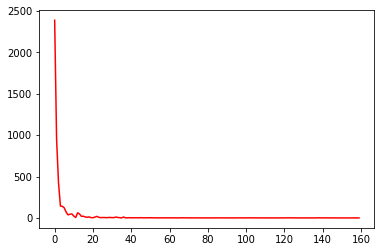

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步骤7：评分(Score Model)

In [22]:
model.eval()
test_loss = 0
correct = 0
predictions = []
target_list = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += F.nll_loss(output, target).item()
        
        # 预测
        output = model(data)
        
        # 计算正确数
        _, predicted = torch.max(output.data, 1)
        predictions.extend(predicted.cpu().numpy())
        target_list.extend(target.cpu())
        correct += (predicted == target).sum().item()

# 平均损失
test_loss /= len(test_loader.dataset) 
# 显示测试结果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count 
print(f'平均损失: {test_loss:.4f}, 准确率: {correct}/{data_count}' + 
      f' ({percentage:.2f}%)\n')

平均损失: 0.3201, 准确率: 89/200 (44.50%)



## 步骤8：评估

## 显示混淆矩阵

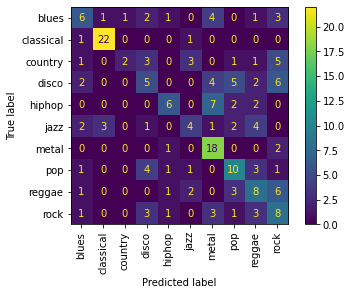

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_list, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gtzan_genres)
disp.plot()
plt.xticks(rotation=90);

In [15]:
# 实际预测 20 笔资料
predictions = []
target_list = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))
        target_list.append(str(target))

# 比对
print('actual    :', ' '.join(target_list))
print('prediction:', ' '.join(predictions[0:20]))

actual    : 3 5 2 6 2 1 2 9 5 7 4 1 8 6 3 9 0 9 2 7
prediction: 7 7 9 6 2 1 9 9 1 8 4 1 9 6 9 9 6 8 3 7


## 步骤9：模型布署

In [16]:
# 模型存档
torch.save(model, 'Music_genre_classification.pth')
# 模型载入
model = torch.load('Music_genre_classification.pth')